In [1]:
import os, sys, re, time, string, unicodedata

import tensorflow as tf
import pickle
import numpy as np
from tensorflow.contrib.learn import DNNClassifier
import time

# Representation
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#Carga stop word
#nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')


/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### funciones y clases "template"

Para normalizar y clasficador , calcular features TFIDF+SVD,  DNN para evular

In [2]:

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
#    return u" ".join(words)
    
    stemmer = SnowballStemmer("spanish")
    out = ""
    for word in words:
        out += stemmer.stem(word)+" "    
    return out

In [3]:
class tfidf_svd:
    def __init__(self, wordbach_trained , svd_trained,non_zero_index_feat,normalize_text):
        """ extractor features"""
        self.wordbach = wordbach_trained
        self.svdT = svd_trained
        self.non_zero_index_feat = non_zero_index_feat
        self.normalize_text = normalize_text
    
    def calc(self,text):
        
        self.tfidf = self.wordbach.transform([self.normalize_text(text)])
        self.tfidf = self.tfidf[:, self.non_zero_index_feat]
        tfidf_svd = self.svdT.transform(self.tfidf)
        return(tfidf_svd)

In [4]:
class DNN_eval:
    def __init__(self, labels, path_model,dim_vec_input):
        """ DNN eval"""
        self.path_model = path_model
        self.labels = labels
        
        self.nClasses = len(self.labels)
        self.feature_columns = [tf.contrib.layers.real_valued_column('x', dimension = dim_vec_input)]
        self.classifier = DNNClassifier(                                
                                   n_classes=len(labels), label_keys=self.labels, 
                                   feature_columns=self.feature_columns,
                                   hidden_units=[2000], 
                                   model_dir = self.path_model                         
                                  )
    def input_fn_evaluate(self):
        input = {'x': tf.constant(self.vec_input )}    
        return input    

    def calc(self,vec_input):
        self.vec_input = vec_input
        #pred_test = self.classifier.predict_classes(input_fn=self.input_fn_evaluate)
        pred_prob = self.classifier.predict_proba(input_fn=self.input_fn_evaluate)
        pred_prob = [x for x in list(pred_prob)]
        y_test_hat = self.labels[np.argmax(pred_prob)]
        #y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
        #y_test_hat = y_test_hat.astype(str)
        return (y_test_hat , pred_prob[0])
    

In [5]:
root_path = "../"

file_name = "tfid_hash28_n10000_svd1000.p"
features_path = root_path + 'data/features/'
features_path_ = features_path + "calcFeat_" + file_name
path_model = root_path + 'models/seccion/info_model.p'



### carga clase extractor features TFIDF+SVF

In [6]:
wb,svdT,non_zero_index_feat = pickle.load( open( features_path_, "rb" ) )

tfidf_svd_model = tfidf_svd(wb,svdT,non_zero_index_feat,normalize_text)  

### carga modelo DNN para inferencia

In [7]:
path_all_models,labels_temas = pickle.load( open( path_model, "rb" ) )

#sec1 = DNN_eval(labels, path_model2,1000)

path_model,labels = pickle.load( open( path_model, "rb" ) )



In [12]:
path_model = path_all_models['economia']
labels = labels_temas['economia']
sec1 = DNN_eval(labels, path_model,1000)


Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f50f48e9ac8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_mode

### evalua una entrada de test 

In [14]:
# evalua 
test_text = 'El Banco Falabella se convertirá en el mayor emisor de tarjetas de crédito del país, después de que la Superintendencia de Bancos e Instituciones Financieras (SBIF) aprobara la integración de CMR Falabella a la compañía. La figura bajo la cual CMR se integra a Banco Falabella es la de Sociedad de Apoyo al Giro (SAG). Con esto, Banco Falabella será el mayor emisor de tarjetas de crédito del país, con una cantidad superior a los 3 millones de ellas activas, según Diario Financiero.'

start = time.time()
test_text = tfidf_svd_model.calc(test_text)
y_test_hat , pred_prob = sec1.calc( vec_input = test_text)

print("end time :" + str(time.time() - start) )
y_test_hat

Normalize text
Extract wordbags
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/seccion/economia/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
end time :2.4189586639404297


'servicios financieros'

### plot

In [18]:
len(labels)

16

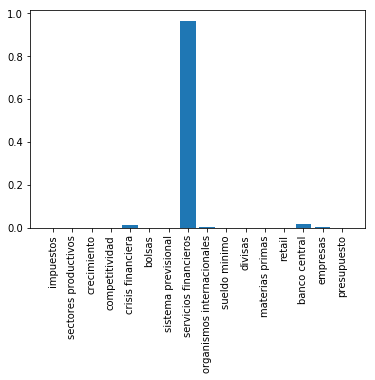

In [21]:
import matplotlib.pyplot as plt


plt.bar(np.arange(len(labels)), pred_prob)
plt.xticks(np.arange(len(labels)), labels)
plt.xticks(rotation=90)
plt.show()